In [13]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

import scipy.stats
import statsmodels.stats.multitest
from scipy.special import logit


from importlib import reload

from pathlib import Path
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

fdr_threshold = 0.05


def comparer(dat, which = [("ase", "beta"),("asb","beta")], threshold = 0.05):
    
    is_sig = [ (dat[ "%s_q%s" % g ] < threshold) for g in which ]    
    for j,k in ((0,1),(1,0)):
        subset_sig = is_sig[j][ is_sig[k] ].mean()
        backg_sig = is_sig[j].mean()
        print("Prop significant for %s (%s)" % which[j], 
              "out of %s (%s) hits:" % which[k], 
              "%.3f" % subset_sig, 
             "(%.3f background rate, x%.2f enrichment)" % (backg_sig, subset_sig/backg_sig))
    effs = [ dat[ "%s_loc%s" % g] for g in which ]
    x_col,y_col = [ "%s_loc%s" % g for g in which ]
    
    print("Correlation of effect sizes %.3f (p=%.3g)" 
          % scipy.stats.pearsonr(dat[x_col],dat[y_col])) 
    sig_in_either = dat[is_sig[0] | is_sig[1]]
    print("Correlation of sig effect sizes %.3f (p=%.3g)" 
          % scipy.stats.pearsonr(sig_in_either[x_col],sig_in_either[y_col])) 
    print("Prop sig effect sizes with matching sign %.3f" 
          % ((sig_in_either[x_col]>0)==(sig_in_either[y_col]>0)).mean())
    
    plt.figure(figsize=(5,4))
    # sns.scatterplot(data = dat, x="%s_loc%s" % which[0], y="%s_loc%s" % which[1], hue = "hue", alpha = 0.1, linewidth=0)
    sns.scatterplot(data = dat[~is_sig[0] & ~is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "insig",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = dat[is_sig[0] & ~is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig for %s%s only" % which[0], 
                    color="red", alpha = 0.2, linewidth=0)
    sns.scatterplot(data = dat[~is_sig[0] & is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig for %s%s only" % which[1], 
                    color="green", alpha = 0.2, linewidth=0)
    sns.scatterplot(data = dat[is_sig[0] & is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig in both",
                    color="blue", alpha = 0.3, linewidth=0)
    #sns.kdeplot(dat.loc[:,x_col], dat.loc[:,y_col], bw_method = 0.1, levels = 4)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()


## Gaussian model replicates for hnRNPK

In [138]:
res = [ pd.read_csv(results_dir / ("normal_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]

In [139]:
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]
res_sub = [ g.loc[:,cols_to_keep] for g in res ]
merged = res_sub[0].merge(res_sub[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
merged

,variantID,refAllele,altAllele,ase_q_1,ase_loc_1,ase_sd_1,asb_q_1,asb_loc_1,asb_sd_1,ase_q_2,ase_loc_2,ase_sd_2,asb_q_2,asb_loc_2,asb_sd_2
0,rs56400883,C,G,0.454672,0.020827,0.182912,0.495183,-0.002375,0.196669,0.147409,-0.195051,0.186186,0.194001,-0.181981,0.210811
1,rs3922851,G,A,0.175234,0.170782,0.182912,0.424916,-0.053586,0.283025,0.492750,-0.003384,0.186186,0.380107,0.067408,0.220866
2,rs3922852,G,C,0.292495,-0.099890,0.182912,0.317117,0.111793,0.234970,0.475512,-0.011436,0.186186,0.156010,-0.223343,0.220914
3,rs10904051,A,G,0.223598,0.139031,0.182912,0.366701,0.073354,0.215365,0.492598,-0.003455,0.186186,0.325057,-0.107113,0.236137
4,rs12245012,G,A,0.453972,-0.021151,0.182912,0.195592,-0.178708,0.208413,0.283060,0.106829,0.186186,0.443382,-0.031483,0.221087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211785,rs10867107,T,C,0.491892,0.003718,0.182912,0.376228,0.062247,0.197356,0.267480,0.115519,0.186186,0.405212,0.050869,0.212060
211786,rs9410071,G,A,0.217672,-0.142686,0.182912,0.492020,-0.005332,0.266573,0.305324,-0.094796,0.186186,0.325955,0.095120,0.210857
211787,rs7357733,G,T,0.493592,0.002938,0.182912,0.290737,-0.147877,0.268266,0.270036,-0.114077,0.186186,0.317067,-0.114966,0.241568
211788,rs766375,C,T,0.477752,0.010206,0.182912,0.293708,0.110621,0.203878,0.322405,-0.085829,0.186186,0.453034,-0.024741,0.209667


Prop significant for asb (_1) out of asb (_2) hits: 0.041 (0.002 background rate, x21.11 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.049 (0.002 background rate, x21.11 enrichment)
Correlation of effect sizes 0.187 (p=0)
Correlation of sig effect sizes 0.447 (p=2.06e-44)
Prop sig effect sizes with matching sign 0.782


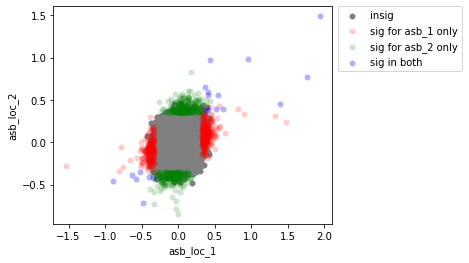

In [140]:
comparer(merged, [("asb","_1"),("asb","_2")])  # 0.16, sigcor 0.30

In [141]:
merged.asb_loc_2.mean()

0.002339286621605148

Why positive effect? Presumably some reference mapping bias effect still. 

In [142]:
xx = (merged.asb_loc_1**2).mean()
yy = (merged.asb_loc_2**2).mean()
xy = (merged.asb_loc_1 * merged.asb_loc_2).mean()
sxx = (merged.asb_sd_1**2).mean()
syy = (merged.asb_sd_2**2).mean()
xx - sxx # these are negative :(
yy - syy
xy 

0.0021890991044262063

## Beta model replicates for hnRNPK

Results are horrible with mean field guide so only considering structured guide here. 

In [143]:
res_beta = [ pd.read_csv(results_dir / ("beta_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]
res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
merged_beta

,variantID,refAllele,altAllele,ase_q_1,ase_loc_1,ase_sd_1,asb_q_1,asb_loc_1,asb_sd_1,ase_q_2,ase_loc_2,ase_sd_2,asb_q_2,asb_loc_2,asb_sd_2
0,rs56400883,C,G,0.337994,0.065037,0.155611,0.329429,0.080115,0.181465,0.160980,-0.145905,0.147314,0.211986,-0.210834,0.263691
1,rs3922851,G,A,0.120245,0.198310,0.168953,0.228672,-0.146637,0.197298,0.357934,0.078545,0.215792,0.494715,0.004027,0.303972
2,rs3922852,G,C,0.212607,-0.145694,0.182710,0.171530,0.190442,0.200859,0.491792,0.003407,0.165606,0.399981,-0.044562,0.175860
3,rs10904051,A,G,0.375697,0.065245,0.205948,0.131784,0.238773,0.213572,0.412670,0.044044,0.199583,0.043882,-0.357291,0.209271
4,rs12245012,G,A,0.174887,-0.208633,0.223130,0.190347,-0.311147,0.354941,0.228832,0.187994,0.253123,0.321138,-0.138695,0.298577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211785,rs10867107,T,C,0.367017,-0.073381,0.215975,0.496182,-0.002792,0.291756,0.211132,0.143822,0.179218,0.451006,-0.025987,0.211068
211786,rs9410071,G,A,0.102073,-0.216359,0.170384,0.419750,0.050402,0.248858,0.442306,0.025264,0.174082,0.358929,-0.094498,0.261533
211787,rs7357733,G,T,0.384697,0.054250,0.185045,0.253200,-0.125225,0.188464,0.225786,-0.154924,0.205797,0.150976,-0.197962,0.191776
211788,rs766375,C,T,0.396006,0.046951,0.178050,0.409456,0.049210,0.214942,0.282998,-0.121615,0.211887,0.407617,0.063408,0.271345


A lot more come out as significant using the beta model

Prop significant for asb (_1) out of asb (_2) hits: 0.145 (0.030 background rate, x4.78 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.135 (0.028 background rate, x4.78 enrichment)
Correlation of effect sizes 0.203 (p=0)
Correlation of sig effect sizes 0.422 (p=0)
Prop sig effect sizes with matching sign 0.705


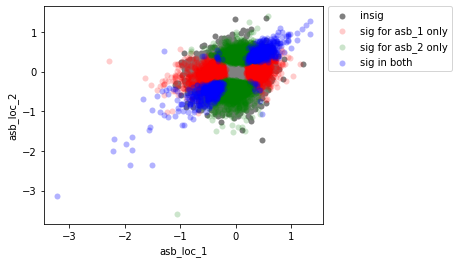

In [144]:
comparer(merged_beta, [("asb","_1"),("asb","_2")])  # 0.20, sigcor 0.41

### Compare ASE to ASB

Replicate 1 -----------
Prop significant for ase () out of asb () hits: 0.358 (0.099 background rate, x3.62 enrichment)
Prop significant for asb () out of ase () hits: 0.091 (0.025 background rate, x3.62 enrichment)
Correlation of effect sizes 0.261 (p=0)
Correlation of sig effect sizes 0.482 (p=0)
Prop sig effect sizes with matching sign 0.700


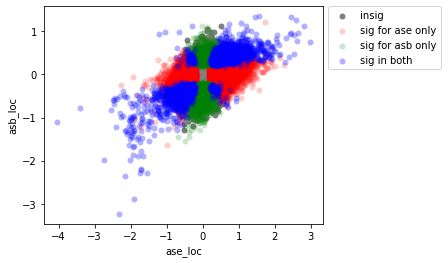

Replicate 2 -----------
Prop significant for ase () out of asb () hits: 0.325 (0.104 background rate, x3.12 enrichment)
Prop significant for asb () out of ase () hits: 0.085 (0.027 background rate, x3.12 enrichment)
Correlation of effect sizes 0.262 (p=0)
Correlation of sig effect sizes 0.458 (p=0)
Prop sig effect sizes with matching sign 0.690


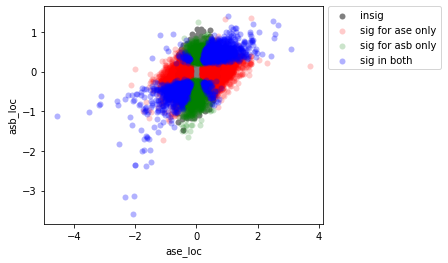

In [145]:
for i in range(2):
    print("Replicate %i -----------" % (i+1))
    comparer(res_sub_beta[i], [("ase",""),("asb","")])          

## Compare across models

In [146]:
comp = [ res_sub[i].merge(res_sub_beta[i], 
                          on = ["variantID", "refAllele", "altAllele"],
                         suffixes = ["_gaus","_beta"]) for i in range(2) ]
comp[0]

,variantID,refAllele,altAllele,ase_q_gaus,ase_loc_gaus,ase_sd_gaus,asb_q_gaus,asb_loc_gaus,asb_sd_gaus,ase_q_beta,ase_loc_beta,ase_sd_beta,asb_q_beta,asb_loc_beta,asb_sd_beta
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791
2,rs12357593,C,T,0.463416,-0.016797,0.182912,0.323245,-0.093211,0.203232,0.398939,-0.056694,0.221380,0.149052,-0.255452,0.245507
3,rs7908298,C,T,0.445290,-0.025163,0.182912,0.247199,0.134557,0.196913,0.498745,0.000623,0.198198,0.367004,-0.077757,0.228831
4,rs7918643,C,T,0.377667,0.056998,0.182912,0.215838,-0.162239,0.206325,0.371479,-0.053385,0.162791,0.299447,-0.140001,0.266165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350632,rs9410071,G,A,0.217672,-0.142686,0.182912,0.492020,-0.005332,0.266573,0.102073,-0.216359,0.170384,0.419750,0.050402,0.248858
350633,rs7357733,G,T,0.493592,0.002938,0.182912,0.290737,-0.147877,0.268266,0.384697,0.054250,0.185045,0.253200,-0.125225,0.188464
350634,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175
350635,rs766375,C,T,0.477752,0.010206,0.182912,0.293708,0.110621,0.203878,0.396006,0.046951,0.178050,0.409456,0.049210,0.214942


Prop significant for asb (_gaus) out of asb (_beta) hits: 0.046 (0.002 background rate, x23.92 enrichment)
Prop significant for asb (_beta) out of asb (_gaus) hits: 0.598 (0.025 background rate, x23.92 enrichment)
Correlation of effect sizes 0.661 (p=0)
Correlation of sig effect sizes 0.809 (p=0)
Prop sig effect sizes with matching sign 0.978


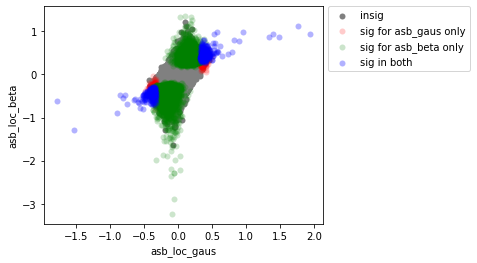

Prop significant for asb (_gaus) out of asb (_beta) hits: 0.051 (0.002 background rate, x22.94 enrichment)
Prop significant for asb (_beta) out of asb (_gaus) hits: 0.627 (0.027 background rate, x22.94 enrichment)
Correlation of effect sizes 0.682 (p=0)
Correlation of sig effect sizes 0.825 (p=0)
Prop sig effect sizes with matching sign 0.984


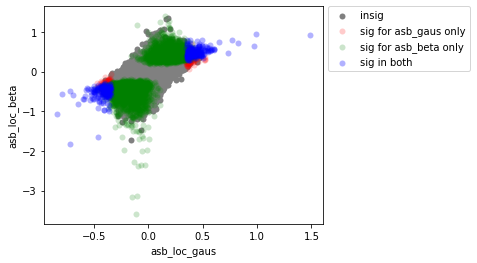

In [147]:
for i in range(2):
    comparer(comp[i], which = [("asb","_gaus"),("asb","_beta")]) # 0.71, .73

## Compare hnRNPA1 and hnRNPK

### Gaussian model

In [148]:
HNRNPA1_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPA1")
hnrnpa1_res = pd.read_csv(HNRNPA1_dir / "normal_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
hnrnpa1_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.468394,-0.014125,0.178108,0.492832,0.003708,0.206388
1,rs10903832,A,G,0.489396,-0.004735,0.178108,0.430062,0.037336,0.211873
2,rs17158753,G,A,0.386755,0.051257,0.178108,0.123363,0.229247,0.197910
3,rs3740304,A,G,0.278711,-0.104492,0.178108,0.186201,0.199967,0.224183
4,rs3125027,T,C,0.272020,0.108061,0.178108,0.443887,0.028675,0.203196
...,...,...,...,...,...,...,...,...,...
261541,rs112278050,C,T,0.389345,0.050053,0.178108,0.410571,0.044846,0.198366
261542,rs9410071,G,A,0.189302,-0.156819,0.178108,0.366194,-0.068584,0.200569
261543,rs766373,A,G,0.462570,-0.016735,0.178108,0.363893,-0.070030,0.201196
261544,rs766375,C,T,0.471521,0.012725,0.178108,0.486300,-0.007706,0.224339


In [149]:
comp = res_sub[0].merge(hnrnpa1_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_hnrnpa1"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_hnrnpa1,ase_loc_hnrnpa1,ase_sd_hnrnpa1,asb_q_hnrnpa1,asb_loc_hnrnpa1,asb_sd_hnrnpa1
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.468394,-0.014125,0.178108,0.492832,0.003708,0.206388
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.489396,-0.004735,0.178108,0.430062,0.037336,0.211873
2,rs4881274,G,A,0.374908,-0.058327,0.182912,0.320340,0.098729,0.211525,0.360234,-0.063733,0.178108,0.485707,0.008603,0.240067
3,rs72478223,C,T,0.452143,-0.021995,0.182912,0.389341,-0.059934,0.213262,0.422412,0.034860,0.178108,0.254957,0.131759,0.199946
4,rs7074740,C,T,0.463195,0.016899,0.182912,0.439604,-0.030145,0.198359,0.477803,0.009915,0.178108,0.448765,0.027943,0.216979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208273,rs1531164,G,A,0.358472,0.066314,0.182912,0.495735,-0.002110,0.197299,0.301708,0.092526,0.178108,0.370546,0.069077,0.209068
208274,rs112278050,C,T,0.416118,0.038747,0.182912,0.374721,0.062911,0.196980,0.389345,0.050053,0.178108,0.410571,0.044846,0.198366
208275,rs9410071,G,A,0.217672,-0.142686,0.182912,0.492020,-0.005332,0.266573,0.189302,-0.156819,0.178108,0.366194,-0.068584,0.200569
208276,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.462570,-0.016735,0.178108,0.363893,-0.070030,0.201196


Prop significant for asb (_hnrnpk) out of asb (_hnrnpa1) hits: 0.033 (0.002 background rate, x19.96 enrichment)
Prop significant for asb (_hnrnpa1) out of asb (_hnrnpk) hits: 0.029 (0.001 background rate, x19.96 enrichment)
Correlation of effect sizes 0.209 (p=0)
Correlation of sig effect sizes 0.391 (p=9.45e-25)
Prop sig effect sizes with matching sign 0.785


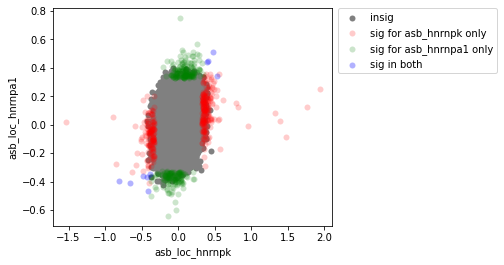

In [150]:
comparer(comp, [("asb","_hnrnpk"),("asb","_hnrnpa1")])


### Beta model

In [151]:
HNRNPA1_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPA1")
hnrnpa1_res = pd.read_csv(HNRNPA1_dir / "beta_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
hnrnpa1_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.081209,-0.295365,0.211430,0.142494,0.363381,0.339869
1,rs10903832,A,G,0.371776,0.063327,0.193570,0.431481,0.058757,0.340416
2,rs17158753,G,A,0.409420,0.051884,0.226532,0.051901,0.392419,0.241237
3,rs3740304,A,G,0.109203,-0.167028,0.135709,0.105418,0.249830,0.199662
4,rs3125027,T,C,0.075299,0.298241,0.207483,0.338859,-0.138918,0.334276
...,...,...,...,...,...,...,...,...,...
261541,rs112278050,C,T,0.169757,0.366768,0.383999,0.315858,-0.250881,0.523417
261542,rs9410071,G,A,0.071566,-0.243013,0.165966,0.414757,0.044989,0.208937
261543,rs766373,A,G,0.369659,-0.076912,0.231134,0.296278,-0.102810,0.192120
261544,rs766375,C,T,0.485023,0.006823,0.181701,0.237483,-0.148679,0.208110


In [152]:
comp = res_sub_beta[0].merge(hnrnpa1_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_hnrnpa1"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_hnrnpa1,ase_loc_hnrnpa1,ase_sd_hnrnpa1,asb_q_hnrnpa1,asb_loc_hnrnpa1,asb_sd_hnrnpa1
0,rs1017361,A,G,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816,0.081209,-0.295365,0.211430,0.142494,0.363381,0.339869
1,rs10903832,A,G,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791,0.371776,0.063327,0.193570,0.431481,0.058757,0.340416
2,rs4881274,G,A,0.350631,-0.059611,0.155392,0.399918,-0.045964,0.181276,0.217284,-0.109055,0.139564,0.400064,0.053469,0.211188
3,rs72478223,C,T,0.303201,-0.125201,0.243005,0.264904,-0.199624,0.317722,0.384442,0.069984,0.238176,0.144164,0.255999,0.241100
4,rs7074740,C,T,0.281477,0.222727,0.385034,0.239264,-0.311975,0.440226,0.258793,0.212135,0.327839,0.312332,-0.198438,0.405595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208273,rs1531164,G,A,0.358332,-0.070008,0.192902,0.374717,0.070938,0.222107,0.499575,0.000214,0.200788,0.483452,0.011717,0.282386
208274,rs112278050,C,T,0.125418,0.504671,0.439485,0.454979,-0.043067,0.380814,0.169757,0.366768,0.383999,0.315858,-0.250881,0.523417
208275,rs9410071,G,A,0.102073,-0.216359,0.170384,0.419750,0.050402,0.248858,0.071566,-0.243013,0.165966,0.414757,0.044989,0.208937
208276,rs766373,A,G,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175,0.369659,-0.076912,0.231134,0.296278,-0.102810,0.192120


Prop significant for asb (_hnrnpk) out of asb (_hnrnpa1) hits: 0.133 (0.028 background rate, x4.81 enrichment)
Prop significant for asb (_hnrnpa1) out of asb (_hnrnpk) hits: 0.108 (0.022 background rate, x4.81 enrichment)
Correlation of effect sizes 0.264 (p=0)
Correlation of sig effect sizes 0.499 (p=0)
Prop sig effect sizes with matching sign 0.748


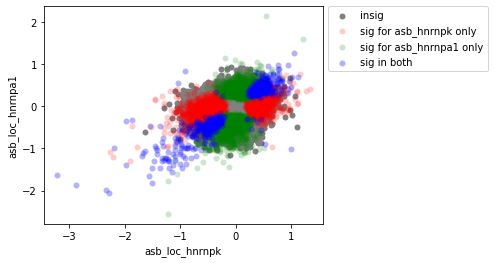

In [153]:
comparer(comp, [("asb","_hnrnpk"),("asb","_hnrnpa1")])


Stronger than the between replicate correlation :( 
So are allelic specific expression effects driving this? 

## Compare RBFOX2 vs hnRNPK

### Gaussian model

In [154]:
RBFOX2_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/RBFOX2")
rbfox2_res = pd.read_csv(RBFOX2_dir / "normal_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
rbfox2_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.452102,-0.022748,0.189009,0.369965,0.077245,0.232704
1,rs10903832,A,G,0.289017,-0.105138,0.189009,0.487074,0.008073,0.249127
2,rs17158753,G,A,0.276690,0.112027,0.189009,0.409577,0.054437,0.238099
3,rs3740304,A,G,0.443586,-0.026818,0.189009,0.404962,-0.056986,0.236924
4,rs2288681,T,C,0.350554,0.072547,0.189009,0.490664,-0.005274,0.225325
...,...,...,...,...,...,...,...,...,...
211953,rs766375,C,T,0.275842,-0.112506,0.189009,0.187436,-0.201680,0.227275
211954,rs72770908,G,A,0.148968,0.196735,0.189009,0.426625,0.044503,0.240589
211955,rs2229948,C,T,0.366169,0.064645,0.189009,0.279332,0.144975,0.247893
211956,rs10867108,C,T,0.391937,-0.051841,0.189009,0.485768,-0.008317,0.233091


In [155]:
comp = res_sub[0].merge(rbfox2_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_rbfox2"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_rbfox2,ase_loc_rbfox2,ase_sd_rbfox2,asb_q_rbfox2,asb_loc_rbfox2,asb_sd_rbfox2
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.452102,-0.022748,0.189009,0.369965,0.077245,0.232704
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.289017,-0.105138,0.189009,0.487074,0.008073,0.249127
2,rs56400883,C,G,0.454672,0.020827,0.182912,0.495183,-0.002375,0.196669,0.497530,-0.001170,0.189009,0.288377,0.168257,0.301464
3,rs3922851,G,A,0.175234,0.170782,0.182912,0.424916,-0.053586,0.283025,0.222053,-0.144645,0.189009,0.311328,-0.111854,0.227305
4,rs3922852,G,C,0.292495,-0.099890,0.182912,0.317117,0.111793,0.234970,0.259117,0.122113,0.189009,0.458966,-0.023747,0.230466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159257,rs62579478,G,A,0.389378,0.051387,0.182912,0.481439,0.013167,0.282894,0.489781,-0.004842,0.189009,0.464141,-0.022825,0.253594
159258,rs10867107,T,C,0.491892,0.003718,0.182912,0.376228,0.062247,0.197356,0.165978,0.183374,0.189009,0.192735,0.197981,0.228126
159259,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.385797,0.054868,0.189009,0.224411,-0.186732,0.246550
159260,rs766375,C,T,0.477752,0.010206,0.182912,0.293708,0.110621,0.203878,0.275842,-0.112506,0.189009,0.187436,-0.201680,0.227275


Prop significant for asb (_hnrnpk) out of asb (_rbfox2) hits: 0.004 (0.002 background rate, x1.96 enrichment)
Prop significant for asb (_rbfox2) out of asb (_hnrnpk) hits: 0.007 (0.003 background rate, x1.96 enrichment)
Correlation of effect sizes 0.109 (p=0)
Correlation of sig effect sizes 0.143 (p=3.22e-05)
Prop sig effect sizes with matching sign 0.625


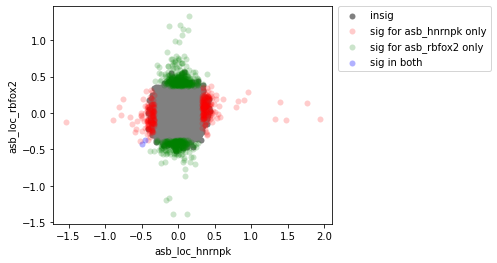

In [156]:
comparer(comp, [("asb","_hnrnpk"),("asb","_rbfox2")])

In [164]:
np.isinf(np.inf)

True

### Beta model

In [157]:
rbfox2_beta = pd.read_csv(RBFOX2_dir / "beta_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
rbfox2_beta

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.330699,-0.126263,0.288283,0.265830,0.196117,0.313550
1,rs10903832,A,G,0.357497,-0.069993,0.191679,0.390770,-0.082658,0.298069
2,rs17158753,G,A,0.265428,0.223440,0.356534,0.393115,0.126472,0.466326
3,rs3740304,A,G,0.155805,-0.149209,0.147462,0.477073,-0.015259,0.265364
4,rs2288681,T,C,0.368312,0.079262,0.235670,0.441763,-0.041551,0.283622
...,...,...,...,...,...,...,...,...,...
211953,rs766375,C,T,0.179159,-0.187636,0.204268,0.121207,-0.322032,0.275483
211954,rs72770908,G,A,0.189384,0.142163,0.161518,0.057602,0.301322,0.191287
211955,rs2229948,C,T,0.372665,-0.063366,0.195091,0.252750,0.158348,0.237809
211956,rs10867108,C,T,0.365727,-0.063479,0.184967,0.456656,-0.022708,0.208593


In [158]:
comp = res_sub_beta[0].merge(rbfox2_beta, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_rbfox2"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_rbfox2,ase_loc_rbfox2,ase_sd_rbfox2,asb_q_rbfox2,asb_loc_rbfox2,asb_sd_rbfox2
0,rs1017361,A,G,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816,0.330699,-0.126263,0.288283,0.265830,0.196117,0.313550
1,rs10903832,A,G,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791,0.357497,-0.069993,0.191679,0.390770,-0.082658,0.298069
2,rs56400883,C,G,0.337994,0.065037,0.155611,0.329429,0.080115,0.181465,0.442032,0.024680,0.169250,0.204275,0.178581,0.216082
3,rs3922851,G,A,0.120245,0.198310,0.168953,0.228672,-0.146637,0.197298,0.482149,0.009594,0.214328,0.157133,-0.232093,0.230638
4,rs3922852,G,C,0.212607,-0.145694,0.182710,0.171530,0.190442,0.200859,0.485219,0.006032,0.162783,0.460145,0.017662,0.176498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159257,rs62579478,G,A,0.418219,-0.033269,0.161145,0.447400,0.022438,0.169682,0.383549,-0.067787,0.228877,0.400188,-0.062112,0.245635
159258,rs10867107,T,C,0.367017,-0.073381,0.215975,0.496182,-0.002792,0.291756,0.216843,0.152968,0.195386,0.249485,0.146575,0.216791
159259,rs766373,A,G,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175,0.495801,-0.001861,0.176774,0.276333,-0.110201,0.185595
159260,rs766375,C,T,0.396006,0.046951,0.178050,0.409456,0.049210,0.214942,0.179159,-0.187636,0.204268,0.121207,-0.322032,0.275483


Prop significant for asb (_hnrnpk) out of asb (_rbfox2) hits: 0.084 (0.031 background rate, x2.74 enrichment)
Prop significant for asb (_rbfox2) out of asb (_hnrnpk) hits: 0.099 (0.036 background rate, x2.74 enrichment)
Correlation of effect sizes 0.131 (p=0)
Correlation of sig effect sizes 0.274 (p=5.31e-174)
Prop sig effect sizes with matching sign 0.629


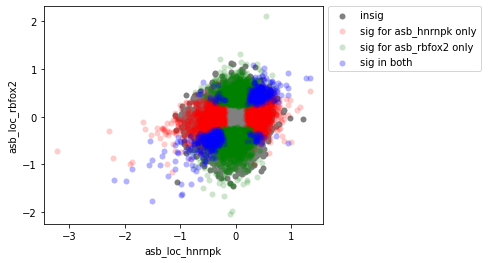

In [159]:
comparer(comp, [("asb","_hnrnpk"),("asb","_rbfox2")])

Stronger than the between replicate correlation :( 
So are allelic specific expression effects driving this? 

## BB LRT

In [16]:
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

res = pd.read_csv(results_dir / ("beta_struct_bblrt_metaan.tsv.gz"), sep = "\t", index_col = False) 

res.rename(columns = {'bb_lrt_p_1' : 'bb_lrt_q_1', 'bb_lrt_p_2' : 'bb_lrt_q_2'}, inplace = True)

In [24]:
pseudo_count = 0.25
for rep in [1,2]: 
    for source in ["input","IP"]:
        res["ratio_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)] + pseudo_count) / ( res["refCount_%s_%i" % (source,rep)] + pseudo_count)

In [25]:
for rep in [1,2]:
    res["bb_lrt_loc_%i" % rep] = np.log(res["ratio_IP_%i" % rep] / res["ratio_input_%i" % rep])

<AxesSubplot:>

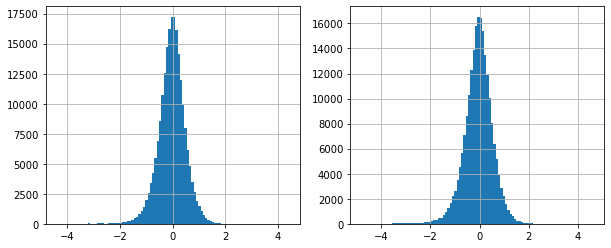

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(121)
res["bb_lrt_loc_1"].hist(bins=100)
plt.subplot(122)
res["bb_lrt_loc_2"].hist(bins=100)

Prop significant for bb_lrt (_1) out of bb_lrt (_2) hits: 0.022 (0.007 background rate, x3.28 enrichment)
Prop significant for bb_lrt (_2) out of bb_lrt (_1) hits: 0.032 (0.010 background rate, x3.28 enrichment)
Correlation of effect sizes 0.094 (p=0)
Correlation of sig effect sizes 0.143 (p=3.36e-17)
Prop sig effect sizes with matching sign 0.597


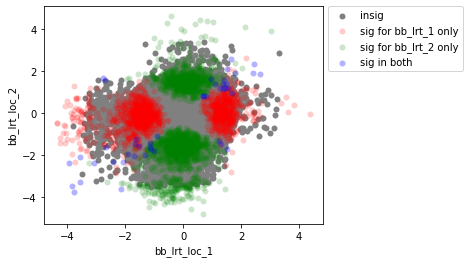

In [34]:
comparer(res, [("bb_lrt","_1"),("bb_lrt","_2")], threshold=0.005)

## BB cdf for ASE

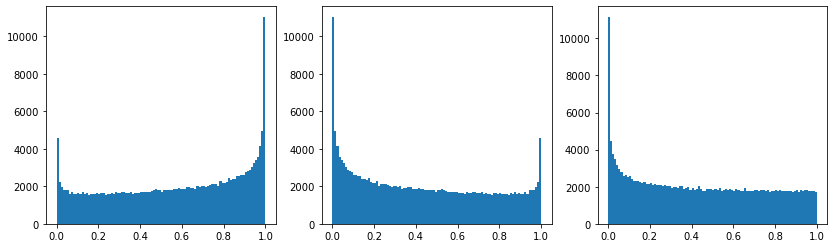

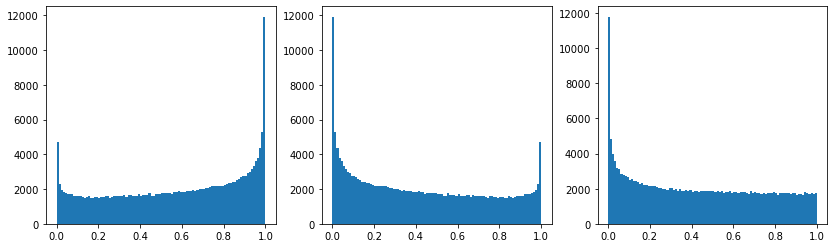

In [85]:
conc = 200. 

for rep in [1,2]:
    pred_ratio = res["pred_ratio_%i" % rep]
    p_alt_low = scipy.stats.betabinom.cdf(res["altCount_input_%i"% rep], res["totalCount_input_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    p_alt_high = scipy.stats.betabinom.sf(res["altCount_input_%i"% rep], res["totalCount_input_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    
    pv = np.minimum(p_alt_low,p_alt_high) * 2
    
    _,res["bb_ase_q_%i" % rep] = statsmodels.stats.multitest.fdrcorrection(pv)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1) 
    _ = plt.hist(p_alt_low, 100)
    plt.subplot(1,3,2)
    _ = plt.hist(p_alt_high, 100)
    plt.subplot(1,3,3)
    _ = plt.hist(pv, 100)


In [78]:
np.mean(lrtq < 0.1)

0.03266915340667643

A lot of SNP have higher than expected alt count, which seems like the opposite of reference mapping bias (!) 

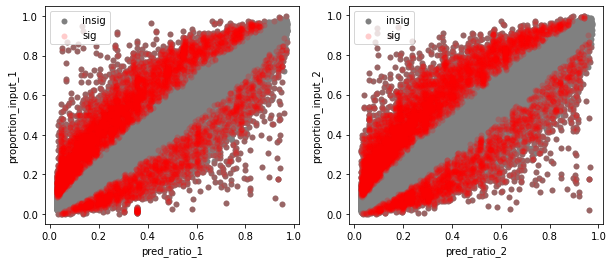

In [86]:
pseudo_count = 0.25
source = "input"
plt.figure(figsize=(10,4))
for rep in [1,2]: 
    plt.subplot(1,2,rep)
    res["proportion_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)]) / ( res["totalCount_%s_%i" % (source,rep)])
    x_col = "pred_ratio_%i" %rep
    y_col = "proportion_input_%i" %rep
    sns.scatterplot(data = res, 
                    x=x_col, 
                    y=y_col, 
                    label = "insig",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = res[ res["bb_ase_q_%i" % rep] < 0.1], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig",
                    color="red", alpha = 0.2, linewidth=0)

In [88]:
ct = pd.crosstab(res["bb_ase_q_1"] < 0.1, res["bb_ase_q_2"] < 0.1)
ct

bb_ase_q_2,False,True
bb_ase_q_1,,
False,199905,4966
True,4356,2563


In [89]:
scipy.stats.chi2_contingency(ct)

(23385.52471196892,
 0.0,
 1,
 array([[197587.966056,   7283.033944],
        [  6673.033944,    245.966056]]))

Prop significant for bb_ase (_1) out of bb_ase (_2) hits: 0.379 (0.022 background rate, x17.12 enrichment)
Prop significant for bb_ase (_2) out of bb_ase (_1) hits: 0.392 (0.023 background rate, x17.12 enrichment)
Correlation of effect sizes 0.379 (p=0)
Correlation of sig effect sizes 0.733 (p=0)
Prop sig effect sizes with matching sign 0.912


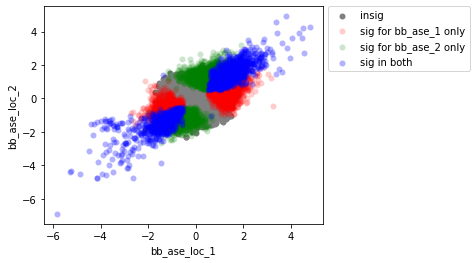

In [122]:
for rep in [1,2]: 
    res["bb_ase_loc_%i" % rep] = logit(res["proportion_input_%i" % rep]) - logit(res["pred_ratio_%i" % rep])
comparer(res, [("bb_ase","_1"),("bb_ase","_2")])

## BB cdf for ASB ignoring ASE

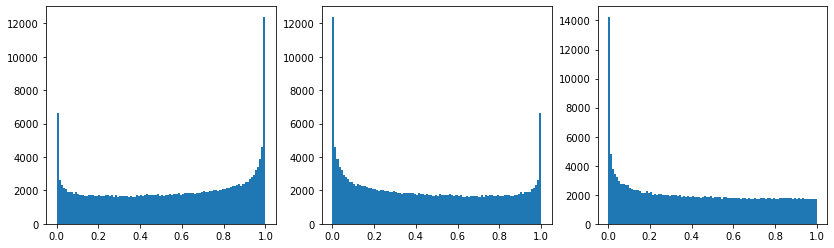

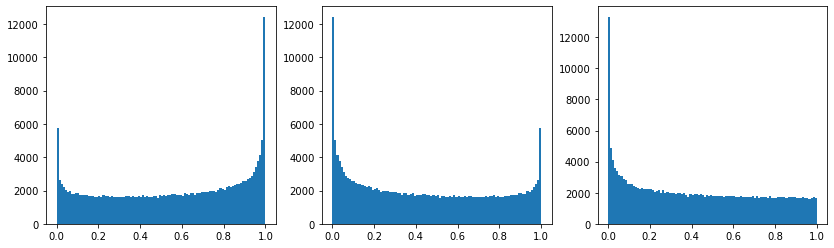

In [117]:
conc = 300. 

for rep in [1,2]:
    pred_ratio = res["pred_ratio_%i" % rep]
    p_alt_low = scipy.stats.betabinom.cdf(res["altCount_IP_%i"% rep], res["totalCount_IP_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    p_alt_high = scipy.stats.betabinom.sf(res["altCount_IP_%i"% rep], res["totalCount_IP_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    
    pv = np.minimum(p_alt_low,p_alt_high) * 2
    
    _,res["bb_asb_q_%i" % rep] = statsmodels.stats.multitest.fdrcorrection(pv)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1) 
    _ = plt.hist(p_alt_low, 100)
    plt.subplot(1,3,2)
    _ = plt.hist(p_alt_high, 100)
    plt.subplot(1,3,3)
    _ = plt.hist(pv, 100)


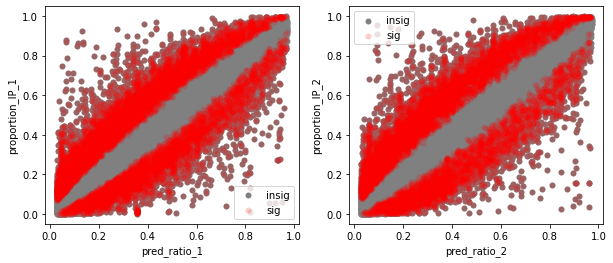

In [118]:
pseudo_count = 0.25
source = "IP"
plt.figure(figsize=(10,4))
for rep in [1,2]: 
    plt.subplot(1,2,rep)
    res["proportion_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)] + pseudo_count) / ( res["totalCount_%s_%i" % (source,rep)] +  2*pseudo_count)
    x_col = "pred_ratio_%i" %rep
    y_col = "proportion_IP_%i" %rep
    sns.scatterplot(data = res, 
                    x=x_col, 
                    y=y_col, 
                    label = "insig",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = res[ res["bb_asb_q_%i" % rep] < 0.1], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig",
                    color="red", alpha = 0.2, linewidth=0)

In [119]:
ct = pd.crosstab(res["bb_asb_q_1"] < 0.1, res["bb_asb_q_2"] < 0.1)
ct

bb_asb_q_2,False,True
bb_asb_q_1,,
False,194952,5537
True,7079,4222


In [120]:
scipy.stats.chi2_contingency(ct)

(29125.180032195298,
 0.0,
 1,
 array([[191250.7349686,   9238.2650314],
        [ 10780.2650314,    520.7349686]]))

Prop significant for bb_asb (_1) out of bb_asb (_2) hits: 0.467 (0.038 background rate, x12.25 enrichment)
Prop significant for bb_asb (_2) out of bb_asb (_1) hits: 0.389 (0.032 background rate, x12.25 enrichment)
Correlation of effect sizes 0.386 (p=0)
Correlation of sig effect sizes 0.720 (p=0)
Prop sig effect sizes with matching sign 0.921


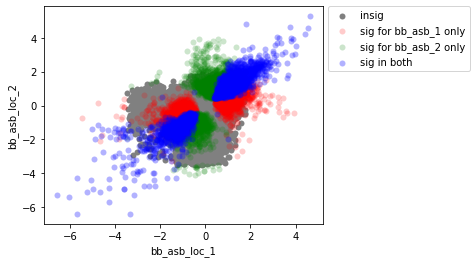

In [121]:
for rep in [1,2]: 
    res["bb_asb_loc_%i" % rep] = logit(res["proportion_IP_%i" % rep]) - logit(res["pred_ratio_%i" % rep])
comparer(res, [("bb_asb","_1"),("bb_asb","_2")])

In [127]:
[ np.mean((res["bb_asb_q_%i" % rep] < 0.1) & (res["bb_ase_q_%i" % rep] > 0.1)) for rep in [1,2] ]

[0.03652202653571934, 0.03145568723735776]

In [129]:
sig = [ (res["bb_asb_q_%i" % rep] < 0.1) & (res["bb_ase_q_%i" % rep] > 0.1) for rep in [1,2] ]

In [131]:
ct = pd.crosstab(sig[0], sig[1])
ct

col_0,False,True
row_0,,
False,198779,5276
True,6349,1386


In [132]:
scipy.stats.chi2_contingency(ct)

(5745.874319771178,
 0.0,
 1,
 array([[197636.30974078,   6418.69025922],
        [  7491.69025922,    243.30974078]]))

In [134]:
res_sub = res[ (res["bb_ase_q_%i" % 1] > 0.1) & (res["bb_ase_q_%i" % 2] > 0.1) ]

ct = pd.crosstab(res_sub["bb_asb_q_1"] < 0.1, res_sub["bb_asb_q_2"] < 0.1)
ct

bb_asb_q_2,False,True
bb_asb_q_1,,
False,188816,4435
True,5268,1386


In [135]:
scipy.stats.chi2_contingency(ct)

(7809.882952292218,
 0.0,
 1,
 array([[187623.75670443,   5627.24329557],
        [  6460.24329557,    193.75670443]]))